# Info

* 스크립트 용도 : 스마트폰 관련 기사 수집 데이터셋 생성하기
<br><br>
* 메타 데이터

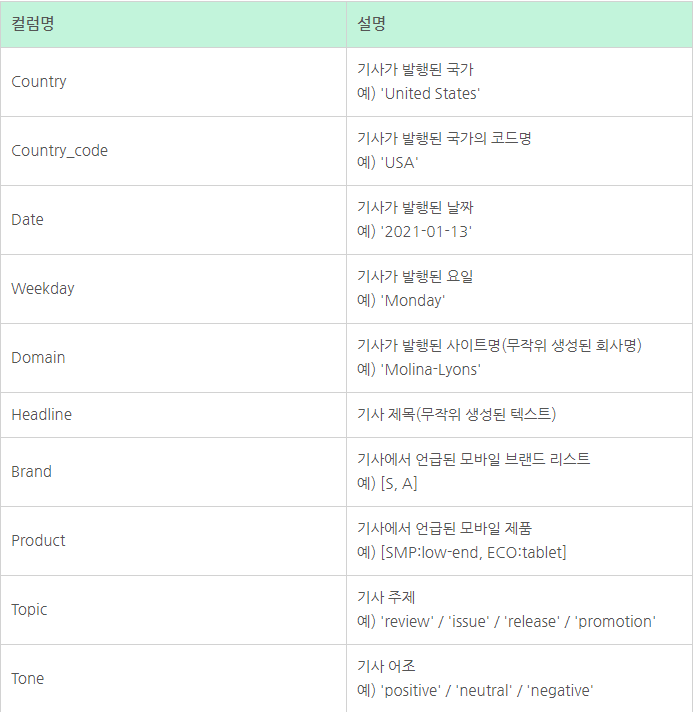
<br><br>
* 생성된 데이터셋 다운로드
    - SMP_Buzz_Raw(2021)_v1.csv
    - SMP_Buzz_Raw(2022)_v1.csv
    - SMP_Buzz_Raw(2023)_v1.csv

https://drive.google.com/drive/folders/1YA2rzoeLSIgtSndS38_fdHE8SM2AG9Sg?usp=sharing
<br><br>
* 분석 시나리오 예시

    당신은 국내 스마트폰 브랜드 'S'의 PR 마케팅팀에 재직 중입니다.

    주요 업무는 보도자료를 작성하는 등, 세계 여러 온라인 매체가 우리 브랜드를 언급하도록 관리하는 것입니다.

    제시된 데이터는 2021~2023년도 전략국가 15개국의 모바일 온라인 기사를 수집한 데이터입니다.

    해당 데이터로부터 팀의 PR 성과를 반영하는 지표를 도출하고, 성과 현황을 분석해 보십시오.

# Settings

In [1]:
class CONFIG :
    seed = 42
    data_path = './data'
    
    display_max_rows = 300
    num_feats_to_display = 100

In [2]:
import os
import gc
import polars as pl
import pandas as pd
import numpy as np
import re
import pickle
import time
from tqdm.autonotebook import tqdm
import joblib
from collections import Counter, defaultdict
import random
from datetime import datetime, timedelta

import pycountry
import pandas_datareader as pdr
from faker import Faker

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

C:\Users\mokj0\AppData\Local\Temp\ipykernel_35868\1009830131.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
tqdm.pandas()

sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', CONFIG.display_max_rows)
warnings.simplefilter('ignore')

random.seed(CONFIG.seed)

# Generating

## 15개 국가별 미디어 리스트 생성

* GDP 데이터(Kaggle 데이터셋 - Country, Regional and World GDP) 가져오기  
* https://www.kaggle.com/datasets/tunguz/country-regional-and-world-gdp
* 국가별 GDP에 비례하게 미디어수를 정하고, 해당 미디어수에 맞게 랜덤 미디어 목록을 생성

In [4]:
gdp_data = pd.read_csv(CONFIG.data_path+'/gdp_csv.csv')

nations_data = gdp_data.copy()
nations_data = nations_data[nations_data.Year==2016]
nations_data = nations_data.sort_values(by='Value', ascending=False)
nations_data = nations_data[["Country Name",'Country Code', 'Value']]
nations_data.columns = ['Country', 'Country_code', 'GDP']
nations_data

,Country,Country_code,GDP
2305,World,WLD,7.584511e+13
718,High income,HIC,4.855746e+13
1656,OECD members,OED,4.755262e+13
1802,Post-demographic dividend,PST,4.521331e+13
832,IDA & IBRD total,IBT,2.797282e+13
1300,Low & middle income,LMY,2.729938e+13
1542,Middle income,MIC,2.689707e+13
775,IBRD only,IBD,2.598148e+13
246,East Asia & Pacific,EAS,2.248043e+13
2248,Upper middle income,UMC,2.062386e+13


In [5]:
non_nations = ['World', 'income', 'OECD', 'demographic', 'IDA', 'IBRD', 'Asia', 'Europe', 'America', 'Euro', 'Africa', 'Arab Word', 'Federation',
               'Fragile and conflict affected situations', 'HIPC', 'Small states', 'developed']
for non_nation in non_nations:
    nations_data = nations_data[~nations_data['Country'].str.contains(non_nation, case=False)]
    
nations_data = nations_data[:15]
nations_data

,Country,Country_code,GDP
11085,United States,USA,1.862448e+13
4102,China,CHN,1.119915e+13
6582,Japan,JPN,4.940159e+12
5443,Germany,DEU,3.477796e+12
11028,United Kingdom,GBR,2.647899e+12
5225,France,FRA,2.465454e+12
6130,India,IND,2.263792e+12
6468,Italy,ITA,1.858913e+12
3469,Brazil,BRA,1.796187e+12
3862,Canada,CAN,1.529760e+12


In [6]:
nations_data['nb_media'] = (nations_data['GDP'] / 10**11).astype(int)
nations_data

,Country,Country_code,GDP,nb_media
11085,United States,USA,1.862448e+13,186
4102,China,CHN,1.119915e+13,111
6582,Japan,JPN,4.940159e+12,49
5443,Germany,DEU,3.477796e+12,34
11028,United Kingdom,GBR,2.647899e+12,26
5225,France,FRA,2.465454e+12,24
6130,India,IND,2.263792e+12,22
6468,Italy,ITA,1.858913e+12,18
3469,Brazil,BRA,1.796187e+12,17
3862,Canada,CAN,1.529760e+12,15


In [7]:
# fake.company()로 랜덤 미디어명 생성
def gen_medias(row) :
    nb = row['nb_media']
    medias = [fake.company() for _ in range(nb)]
    return medias 

fake = Faker()
nations_data['media_list'] = nations_data.apply(gen_medias, axis=1)
nations_data

,Country,Country_code,GDP,nb_media,media_list
11085,United States,USA,1.862448e+13,186,"[Jennings, Parker and Smith, Smith, Coleman an..."
4102,China,CHN,1.119915e+13,111,"[Villa and Sons, Joyce, Williams and Collins, ..."
6582,Japan,JPN,4.940159e+12,49,"[Cooke-Williams, Page, Hicks and Matthews, Val..."
5443,Germany,DEU,3.477796e+12,34,"[Barrett Group, Wiley-Howell, Collins-Curtis, ..."
11028,United Kingdom,GBR,2.647899e+12,26,"[Thomas-Blair, Perez-Smith, Tran-Robinson, Oli..."
5225,France,FRA,2.465454e+12,24,"[Christensen PLC, Wang-Blake, Johnson-Hoover, ..."
6130,India,IND,2.263792e+12,22,"[Jensen, Allen and Newton, Mccoy, Whitney and ..."
6468,Italy,ITA,1.858913e+12,18,"[Moore, Barker and Williams, Rocha Inc, Elliso..."
3469,Brazil,BRA,1.796187e+12,17,"[Graham-Davis, Klein, Crane and Rodriguez, Mul..."
3862,Canada,CAN,1.529760e+12,15,"[Garcia, Wheeler and Mcfarland, Armstrong Ltd,..."


## 국가별 기사 생성을 위한 기사수 베이스라인 세팅

국가별 기사 랜덤 생성을 위해
* 국가별 기사량 베이스라인(월 기준) 설정한 후,
* 해당 기사량 내 브랜드/제품/토픽/기사 어조의 비중 설정
* 월별 수치 차별화 위해, 월별 S, A, G 브랜드 가중치 추가

In [8]:
# 국가별 브랜드 / 제품 / 토픽 / 기사 어조 비중 세팅
def set_gen_params(country) :
    if country in ['KOR'] :
        brands = {'S':50, 'A':37, 'G':5, 'X':3, 'H':3, 'O':2}
        products = {'SMP:low-end':10, 'SMP:mid-end':15, 'SMP:high-end':40, 'ECO:earbuds':15, 'ECO:tablet':10, 'accessory':5, 'service':5}
        topics = {'issue':20, 'review':35, 'release':30, 'promotion':15}
        tones = {'positive': 20, 'neutral': 70, 'negative': 10}
        
    elif country in ['CHN'] :
        brands = {'S':8, 'A':25, 'G':2, 'X':22, 'H':23, 'O':20}
        products = {'SMP:low-end':10, 'SMP:mid-end':15, 'SMP:high-end':40, 'ECO:earbuds':15, 'ECO:tablet':10, 'accessory':5, 'service':5}
        topics = {'issue':20, 'review':35, 'release':30, 'promotion':15}
        tones = {'positive': 20, 'neutral': 70, 'negative': 10}
        
    elif country in ['India', 'Brazil', 'Mexico', 'Indonesia'] :
        brands = {'S':30, 'A':30, 'G':10, 'X':10, 'H':10, 'O':10}
        products = {'SMP:low-end':30, 'SMP:mid-end':30, 'SMP:high-end':10, 'ECO:earbuds':12, 'ECO:tablet':3, 'accessory':10, 'service':5}
        topics = {'issue':20, 'review':35, 'release':30, 'promotion':15}
        tones = {'positive': 20, 'neutral': 65, 'negative': 15}
        
    else :
        brands = {'S':25, 'A':44, 'G':10, 'X':8, 'H':7, 'O':6}
        products = {'SMP:low-end':10, 'SMP:mid-end':15, 'SMP:high-end':40, 'ECO:earbuds':15, 'ECO:tablet':10, 'accessory':5, 'service':5}
        topics = {'issue':20, 'review':35, 'release':30, 'promotion':15}
        tones = {'positive': 20, 'neutral': 65, 'negative': 15}
    
    medias_pre = nations_data.loc[nations_data.Country_code=='USA', 'media_list'].values[0]
    medias = {}
    t = len(medias_pre)
    for media in medias_pre :
        medias[media] = t
        t -= 1
    
    result_dict = {'brands':brands, 'products':products, 'topics':topics, 'tones':tones, 'medias':medias}
    return result_dict

# 월별 브랜드 S, A, G의 가중치 세팅
def set_plus_ws(month) :
    if month == 1 :
        w_s = 100
        w_a = 10
        w_g = 0
    elif month == 2 :
        w_s = 50
        w_a = 50
        w_g = 0
    elif month == 3 :
        w_s = 0
        w_a = 100
        w_g = 0
    elif month == 4 :
        w_s = 0
        w_a = 20
        w_g = 0
    elif month == 5 :
        w_s = 0
        w_a = 20
        w_g = 0
    elif month == 6 :
        w_s = 20
        w_a = 40
        w_g = 0
    elif month == 7 :
        w_s = 50
        w_a = 0
        w_g = 0
    elif month == 8 :
        w_s = 100
        w_a = 50
        w_g = 0
    elif month == 9 :
        w_s = 30
        w_a = 100
        w_g = 20
    elif month == 10 :
        w_s = 10
        w_a = 30
        w_g = 30
    elif month == 11 :
        w_s = 0
        w_a = 10
        w_g = 0
    elif month == 12 :
        w_s = 0
        w_a = 0
        w_g = 0
    return {'w_s':w_s, 'w_a':w_a, 'w_g':w_g}

# 국가별 기사량 베이스라인
baseline = {'USA': 3000,
            'CHN': 2000,
            'JPN': 1500,
            'DEU': 1500,
            'GBR': 1500,
            'FRA': 1500,
            'IND': 1000,
            'ITA': 1000,
            'BRA': 1000,
            'CAN': 1000,
            'KOR': 1500,
            'ESP': 1000,
            'AUS': 500,
            'MEX': 300,
            'IDN': 300}

## 2021~2023 국가별 기사량 랜덤 생성

In [9]:
monthly_df = nations_data[['Country', 'Country_code']].copy()
countries = list(monthly_df.Country_code.values)
for year in [2021, 2022, 2023] :
    for month in range(1, 13) :
        values = []
        for cc in countries :
            origin_v = int(baseline[cc] * random.uniform(0.9, 1.1))
            ws_dict = set_plus_ws(month)
            value = origin_v * (100+ ws_dict['w_s'] + ws_dict['w_a'] + ws_dict['w_g']) / 100
            values.append(int(value))
        monthly_df[str(year) +'_'+ str(month)] = values
    
monthly_df

,Country,Country_code,2021_1,2021_2,2021_3,2021_4,2021_5,2021_6,2021_7,2021_8,2021_9,2021_10,2021_11,2021_12,2022_1,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10,2022_11,2022_12,2023_1,2023_2,2023_3,2023_4,2023_5,2023_6,2023_7,2023_8,2023_9,2023_10,2023_11,2023_12
11085,United States,USA,6474,6052,6368,3406,3951,4699,4147,7710,7892,5084,3626,2742,6587,6432,5718,3660,3541,5275,4785,8107,8105,5491,3504,3218,6587,5482,6482,3361,3537,4368,4857,6957,7320,5281,3108,3152
4102,China,CHN,3801,3776,4182,2208,2466,3464,3075,4610,5037,3105,2264,1895,4344,4040,4226,2401,2439,2926,2878,5345,5045,3335,2096,2186,4042,4130,4092,2199,2461,3038,3145,4730,4505,3333,2123,2179
6582,Japan,JPN,3007,3052,3020,1719,1820,2379,2380,3700,3957,2682,1629,1550,3454,2730,2972,1926,1807,2260,2323,3442,4000,2611,1744,1433,3215,2898,2880,1804,1689,2566,2238,3895,3637,2378,1735,1409
5443,Germany,DEU,2973,3184,3282,1848,1866,2286,2214,3715,3772,2684,1655,1414,2895,3298,2952,1676,1956,2286,2446,3692,3810,2373,1520,1542,3156,2888,3028,1846,1869,2377,2140,3902,3940,2533,1609,1356
11028,United Kingdom,GBR,3297,2702,2926,1750,1922,2276,2053,4090,3375,2359,1524,1389,3087,3200,3274,1965,1693,2606,2085,3582,3485,2767,1772,1469,3076,3208,2700,1740,1797,2544,2136,3422,4015,2359,1732,1395
5225,France,FRA,3261,3182,3030,1753,1898,2428,2196,4030,3617,2536,1558,1630,3047,3280,3296,1648,1876,2582,2076,3377,3470,2735,1767,1644,3196,3130,2872,1914,1707,2480,2311,3680,4090,2611,1758,1387
6130,India,IND,2263,2078,2130,1129,1134,1523,1648,2380,2257,1715,1063,1014,2251,2170,2022,1124,1136,1720,1381,2635,2402,1861,1038,1007,1995,1920,1970,1260,1237,1755,1579,2520,2457,1538,1045,1033
6468,Italy,ITA,1925,1936,2046,1143,1087,1625,1507,2500,2712,1620,1118,994,1992,2138,2086,1222,1174,1556,1515,2567,2697,1805,1169,1087,2186,1922,2030,1240,1081,1630,1506,2457,2622,1662,1007,1012
3469,Brazil,BRA,2066,1862,2144,1304,1155,1726,1641,2337,2687,1825,1040,1056,1969,1866,1860,1242,1240,1489,1431,2380,2647,1829,1091,923,1890,1962,2060,1132,1260,1744,1537,2352,2522,1720,993,943
3862,Canada,CAN,1900,2182,2030,1234,1143,1566,1608,2705,2665,1672,1038,1061,2076,1994,1918,1136,1150,1705,1530,2620,2680,1536,1057,1094,2278,1960,1984,1126,1264,1724,1431,2460,2550,1538,1107,1039


## 2021~2023 기사 수집 로데이터 생성

* 국가X월 데이터에 기반해, 기사 데이터 생성
* 기사 발행일, 미디어, 무작위 생성 제목, 언급된 브랜드, 언급된 제품, 기사 주제, 기사 어조 태그를 위에서 세팅한 비중 정보에 따라 부여

In [10]:
# 기사가 언급하는 브랜드 개수별 확률. 예) 1개 브랜드 언급 60/100. 2개 브랜드 언급 25/100. 제품도 마찬가지.
brands_nb_list = [1]*60 + [2]*25 + [3]*10 + [4]*2 + [5]*2 + [6]*1
products_nb_list = [1]*30 + [2]*35 + [3]*20 + [4]*10 + [5]*3 + [6]*1 + [7]*1

def get_pool(item_list) :
    return [item for item, count in item_list.items() for _ in range(count)]

def gen_tags(country_code, month) :
    tags_dict = set_gen_params(country_code)
    brands = tags_dict['brands']
    products = tags_dict['products']
    topics = tags_dict['topics']
    tones = tags_dict['tones']
    medias = tags_dict['medias']
    
    nb_brands = random.choice(brands_nb_list)
    nb_products = random.choice(products_nb_list)
    
    ws = set_plus_ws(month)
    ws = {'S':ws['w_s'], 'A':ws['w_a'], 'G':ws['w_g']}
    
    brand_pool = get_pool(brands)
    brand_pool += get_pool(ws)
    brand_picked = list(np.unique(random.sample(brand_pool, nb_brands)))
    
    products_pool = get_pool(products)
    product_picked = list(np.unique(random.sample(products_pool, nb_products)))
    
    topics_pool = get_pool(topics)
    topic_picked = random.choice(topics_pool)
    
    tones_pool = get_pool(tones)
    tone_picked = random.choice(tones_pool)
    
    medias_pool = get_pool(medias)
    media_picked = random.choice(medias_pool)
    
    return {'Brand':brand_picked, 'Product':product_picked, 'Topic':topic_picked, 'Tone':tone_picked, 'Domain':media_picked}

def gen_day(year, month) :
    if month == 12:
        next_month_first_day = datetime(year+1, 1, 1)
    else:
        next_month_first_day = datetime(year, month+1, 1)
    last_day_of_month = next_month_first_day - timedelta(days=1)
    
    while True:
        day = random.randint(1, last_day_of_month.day)
        weekday = datetime(year, month, day).weekday()
        if weekday in [5, 6] :
            rand = random.choice(list(range(100)))
            if rand < 20 :
                break
        else :
            break
            
    return {'Day':day, 'Weekday':weekday}

In [11]:
%%time
inputs = {'Country': [],
          'Country_code': [],
          'Year': [],
          'Month': [],
          'Day': [],
          'Weekday': [],
          'Domain': [],
          'Headline': [],
          'Brand': [],
          'Product': [],
          'Topic': [],
          'Tone' : []}

for country_code in tqdm(monthly_df.Country_code) :
    for year in [2021, 2022, 2023] :
        for month in range(1, 13) :
            monthly_value = monthly_df.loc[monthly_df.Country_code==country_code, f'{year}_{month}'].values[0]
            country_value = monthly_df.loc[monthly_df.Country_code==country_code, 'Country'].values[0]
            for ii in range(monthly_value) :
                inputs['Country'].append(country_value)
                inputs['Country_code'].append(country_code)
                inputs['Year'].append(year)
                inputs['Month'].append(month)
                inputs['Headline'].append(fake.text())
                
                tags_dict = gen_tags(country_code, month)
                for k in tags_dict.keys() :
                    inputs[k].append(tags_dict[k])
                    
                day_dict = gen_day(year, month)
                for k in day_dict.keys() :
                    inputs[k].append(day_dict[k])
                
raw_df = pd.DataFrame(inputs)
raw_df.shape

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 10min 50s
Wall time: 10min 51s


(1139706, 12)

In [12]:
raw_df['Date'] = pd.to_datetime(raw_df[['Year', 'Month', 'Day']])
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
raw_df['Weekday'] = raw_df['Weekday'].apply(lambda x: weekdays[x])
raw_df = raw_df[['Country', 'Country_code', 'Date', 'Weekday', 'Domain', 'Headline', 'Brand', 'Product', 'Topic', 'Tone']]
raw_df

,Country,Country_code,Date,Weekday,Domain,Headline,Brand,Product,Topic,Tone
0,United States,USA,2021-01-13,Wednesday,Porter LLC,Necessary citizen crime performance theory sha...,[A],"[ECO:earbuds, SMP:low-end]",review,neutral
1,United States,USA,2021-01-28,Thursday,Ford-Weeks,Condition evidence commercial though. Name pro...,[S],[ECO:tablet],review,positive
2,United States,USA,2021-01-21,Thursday,"Vance, Townsend and Bauer",Her history marriage seven no ahead sometimes....,[A],"[ECO:earbuds, SMP:high-end, SMP:low-end]",release,neutral
3,United States,USA,2021-01-21,Thursday,Edwards Group,Onto ready I wife.\nSong gas six network that ...,[S],[SMP:high-end],issue,neutral
4,United States,USA,2021-01-15,Friday,"Hines, Peck and Hanson",Red explain few security who despite. Foreign ...,[A],"[ECO:earbuds, SMP:high-end, SMP:mid-end, acces...",release,neutral
...,...,...,...,...,...,...,...,...,...,...
1139701,Indonesia,IDN,2023-12-06,Wednesday,"Walker, Mitchell and Collins",Age expert last party southern control. Detail...,[O],[SMP:high-end],issue,neutral
1139702,Indonesia,IDN,2023-12-08,Friday,Woods Inc,Event window indicate role. Second look someti...,[H],"[ECO:tablet, SMP:high-end, SMP:mid-end]",issue,neutral
1139703,Indonesia,IDN,2023-12-29,Friday,Booth-Brown,Part learn yard tree beautiful light argue. Co...,[X],[ECO:tablet],review,positive
1139704,Indonesia,IDN,2023-12-19,Tuesday,Ryan-Chavez,Trip staff few.\nProduct PM hotel child. Near ...,"[O, S]",[SMP:low-end],release,neutral


## 기사 로데이터 연도별 분할 저장

In [13]:
raw_df1 = raw_df[(raw_df.Date >= '2021')&(raw_df.Date < '2022')]
raw_df2 = raw_df[(raw_df.Date >= '2022')&(raw_df.Date < '2023')]
raw_df3 = raw_df[(raw_df.Date >= '2023')]

In [14]:
raw_df1.to_csv(CONFIG.data_path+'/SMP_Buzz_Raw(2021)_v1.csv', index=True)
raw_df2.to_csv(CONFIG.data_path+'/SMP_Buzz_Raw(2022)_v1.csv', index=True)
raw_df3.to_csv(CONFIG.data_path+'/SMP_Buzz_Raw(2023)_v1.csv', index=True)